<a href="https://colab.research.google.com/github/Blaze-coder3/Bharat-Intern/blob/main/iris_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Keras Tuner Installation**

In [ ]:
pip install keras-tuner

**Import necessary libraries and modules**

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from kerastuner.tuners import RandomSearch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

**Data Preparation for Iris Flower Classification: Loading, Encoding, and Standardization**

In [ ]:
# Load Iris dataset
iris = datasets.load_iris()
data = pd.DataFrame(data=np.c_[iris['data'], iris['target']], columns=iris['feature_names'] + ['target'])

# Split the dataset into features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



**Neural Network Architecture Definition for Iris Flower Classification: Hyperparameter Tuning and Model Compilation**

In [ ]:
# Define a more complex neural network architecture
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=4, max_value=32, step=4), input_dim=4, activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=4, max_value=32, step=4), activation='relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


**Hyperparameter Tuning and Model Evaluation: RandomSearch, Best Model Retrieval, and Performance Metrics**

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Use RandomSearch for hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='iris_classification'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Get the best model and summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Evaluate the best model on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


Reloading Tuner from my_dir/iris_classification/tuner0.json


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                252       
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 52        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1


**Model Evaluation and Visualizations: Training History, Confusion Matrix, Class Distribution, Histograms, Scatter Plots, ROC Curve, Precision-Recall Curve**

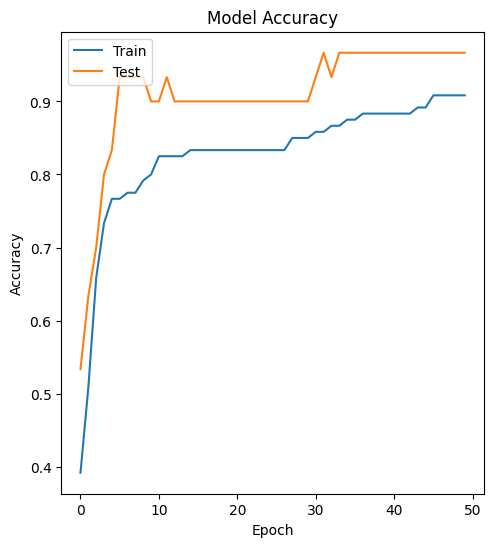

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

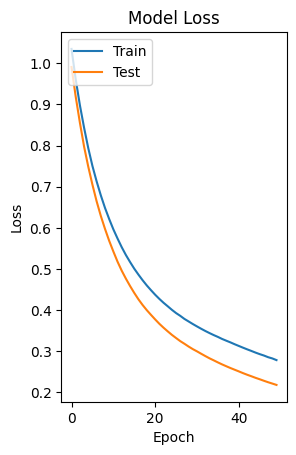

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

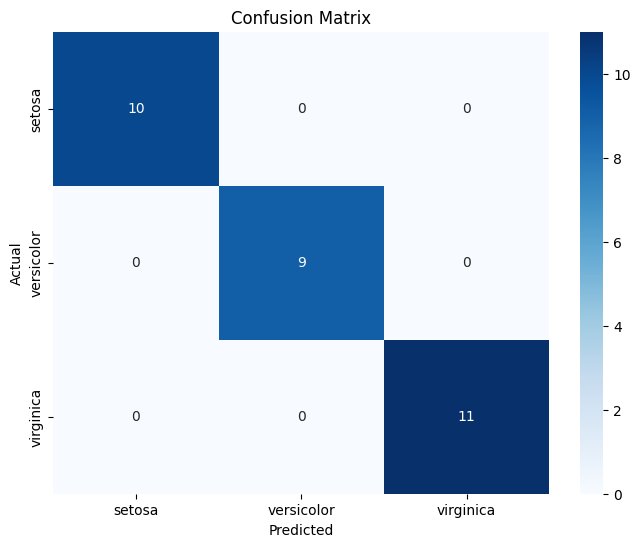

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

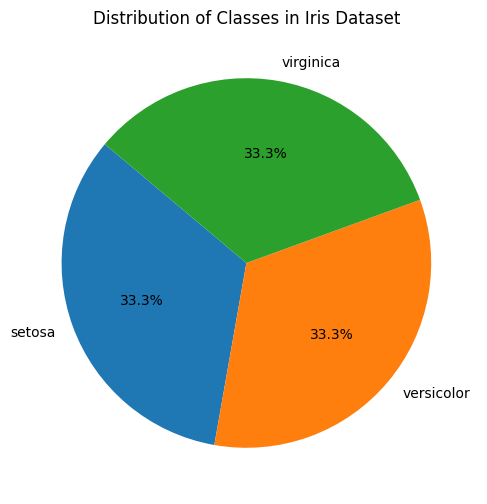

In [ ]:
# Pie chart for distribution of classes
class_distribution = data['target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=iris.target_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes in Iris Dataset')
plt.show()

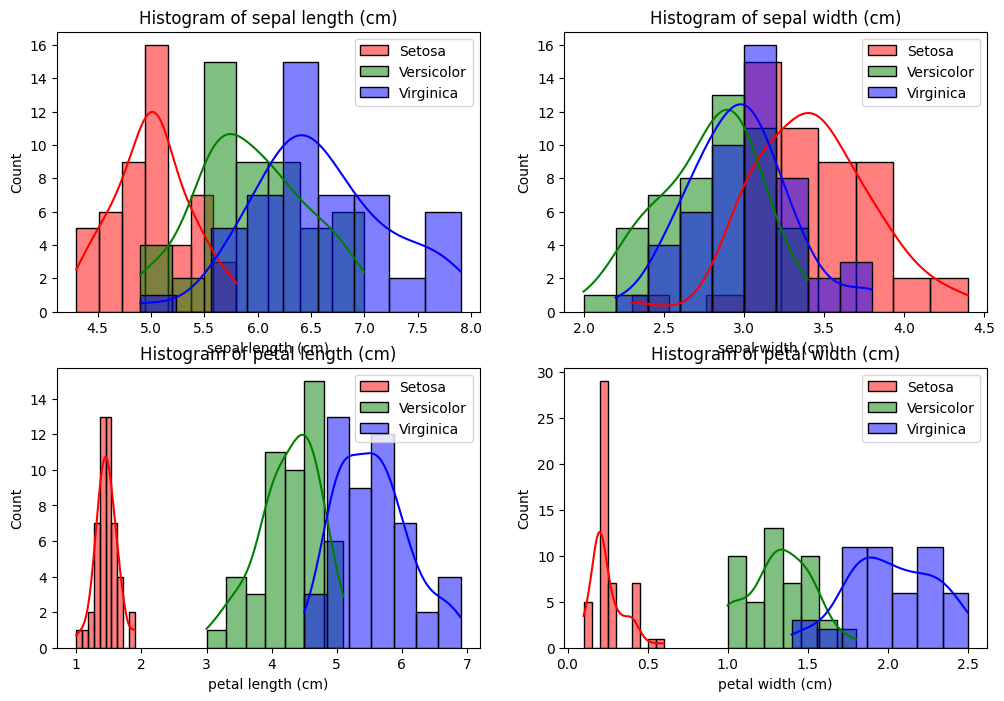

In [ ]:
# Visualizations
def plot_histograms(data, features, target):
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(features, 1):
        plt.subplot(2, 2, i)
        sns.histplot(data[data[target] == 0][feature], color='r', label='Setosa', kde=True)
        sns.histplot(data[data[target] == 1][feature], color='g', label='Versicolor', kde=True)
        sns.histplot(data[data[target] == 2][feature], color='b', label='Virginica', kde=True)
        plt.title(f'Histogram of {feature}')
        plt.legend()

plot_histograms(data, iris['feature_names'], 'target')
plt.show()


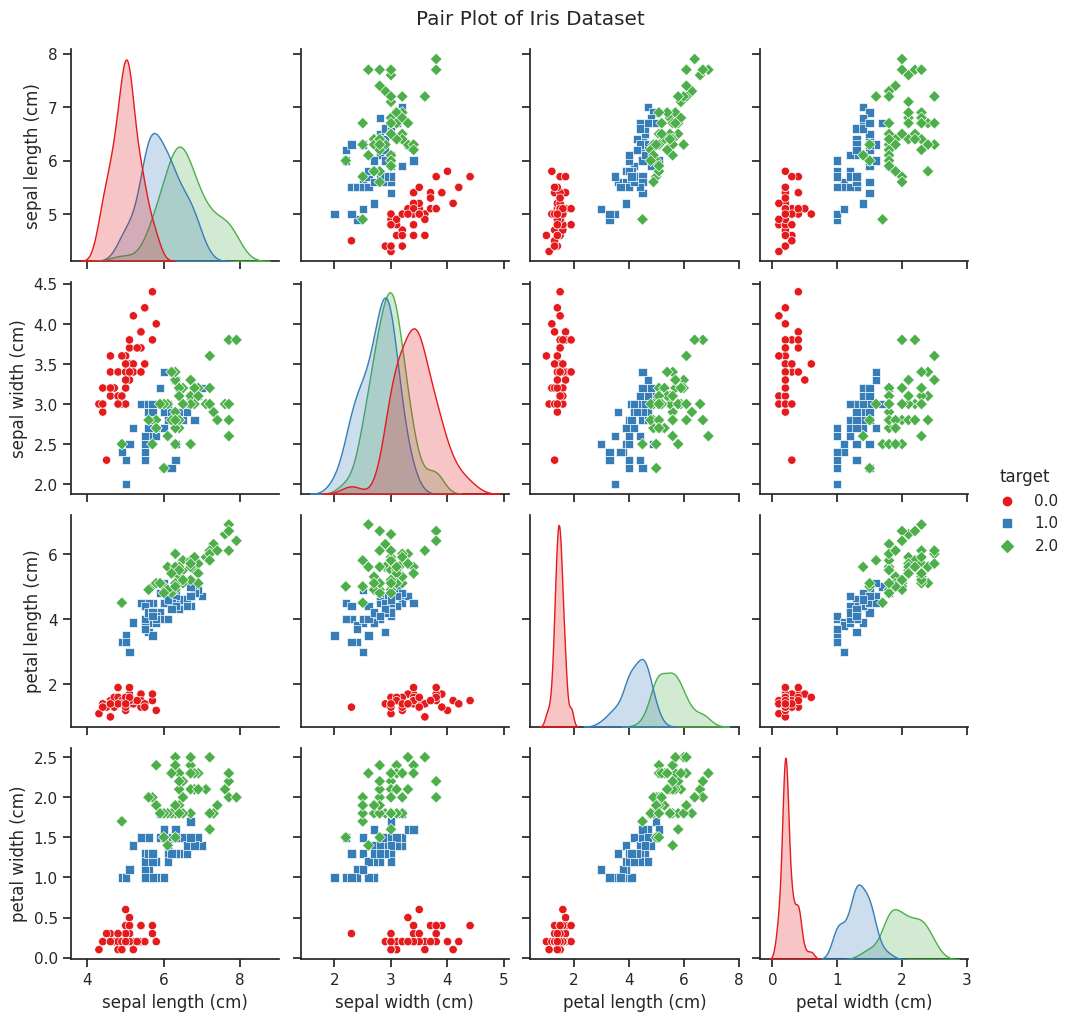

In [ ]:
# Scatter plots
def plot_scatter_matrix(data, features, target):
    sns.set(style="ticks")
    sns.pairplot(data, hue=target, markers=["o", "s", "D"], palette='Set1')
    plt.suptitle("Pair Plot of Iris Dataset", y=1.02)
    plt.show()

plot_scatter_matrix(data, iris['feature_names'], 'target')

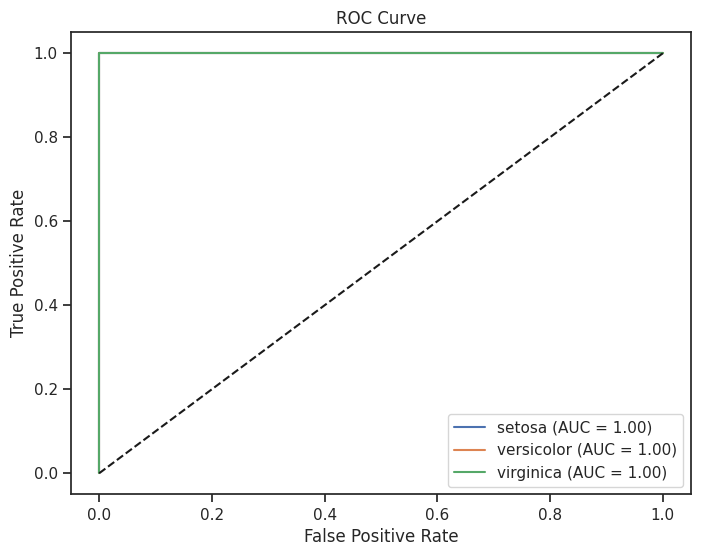

In [ ]:
# ROC Curve
import sklearn

def plot_roc_curve(y_test, y_pred_probs):
    plt.figure(figsize=(8, 6))
    for i in range(3):
        fpr, tpr, thresholds = sklearn.metrics.roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{iris.target_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred_probs)

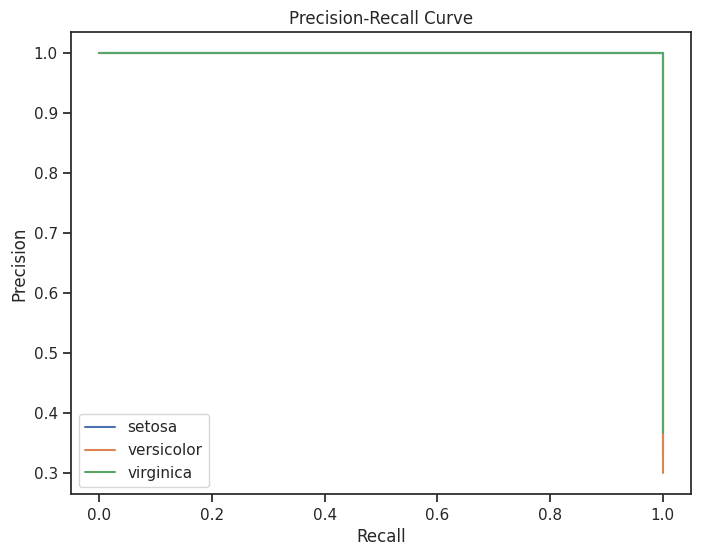

In [ ]:
import sklearn.metrics

# Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_pred_probs):
    plt.figure(figsize=(8, 6))
    for i in range(3):
        precision, recall, thresholds = sklearn.metrics.precision_recall_curve((y_test == i).astype(int), y_pred_probs[:, i])
        plt.plot(recall, precision, label=f'{iris.target_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_precision_recall_curve(y_test, y_pred_probs)